In [1]:
# Importing Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Conv1D
import wfdb                            # Package for loading the ecg and annotation
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore") 
import random
from keras.layers import Bidirectional, LSTM
# Random Initialization
random.seed(42)

# **Importing Data**

In [2]:
# Importing Data
data = '../input/mit-bih-arrhythmia-database/'

In [3]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

#  **Analysing Data**

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()


for pts in patients:
    file = data + pts
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

In [5]:
# Symbols Dataframe
symbols_df

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [6]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

# **Data Transformation**

In [7]:
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Normal Beat Symbols
normal = ['N']

In [8]:
# Classifying normal, abnormal or nonbeat
symbols_df['category'] = -1
symbols_df.loc[symbols_df.symbol == 'N','category'] = 0
symbols_df.loc[symbols_df.symbol.isin(abnormal), 'category'] = 1

In [9]:
# Value counts of different categories
symbols_df.groupby('category').Counts.sum()

category
-1     3186
 0    75052
 1    34409
Name: Counts, dtype: int64

In [10]:
symbols_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 4
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   symbol          283 non-null    object
 1   Counts          283 non-null    int64 
 2   Patient Number  283 non-null    object
 3   category        283 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.1+ KB


In [11]:
def load_ecg(file):    
    
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [12]:
# Accessing the ecg points for 
file = data + patients[8]

In [13]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [14]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


> # **Data Visualization**

In [15]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[4105, 10876, 83824, 107330, 180041, 180621, 193553, 205731, 221206, 263192]

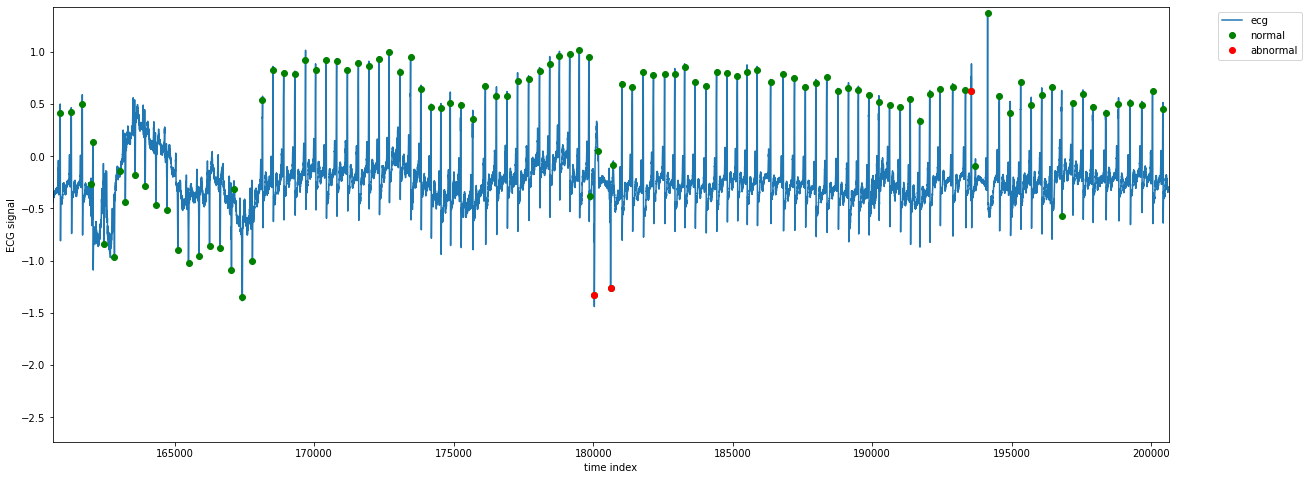

In [16]:
# Generating evenly spaced values
x = np.arange(len(p_signal))

left = ab_index[5]-20000
right = ab_index[5]+20000

plt.figure(figsize=(20,8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

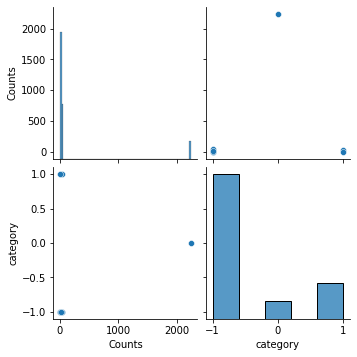

In [17]:
columns=["symbol","Counts","Patient Number","category"]
s2_df=symbols_df[~symbols_df.index.duplicated()]

sns.pairplot(s2_df[columns])

<Figure size 720x576 with 0 Axes>

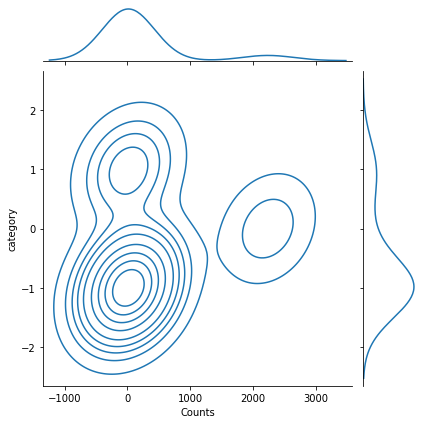

In [18]:
plt.figure(figsize=(10,8))
sns.jointplot(x=s2_df["Counts"], y=s2_df["category"], kind="kde")
plt.show()

# **Data Preprocessing**

In [19]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
       
        p_signal = p_signal[:,0]
        
        
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


In [20]:
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [21]:
# Parameter Values
num_sec = 3
fs = 360

In [22]:
# Accessing the fuction and creating a dataset with ECG digital Points
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal)

In [23]:
# Train Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

# **Training Model - DNN(Deep Neural Network)**

In [24]:
# Relu for activation function and drop out for regularization
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [25]:
# Compiling model with  binary crossentropy and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [26]:
# Fitting the model
model.fit(X_train, y_train, batch_size = 32, epochs= 10, verbose = 1)

Epoch 1/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.2387 - accuracy: 0.9099
Epoch 2/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.1612 - accuracy: 0.9484
Epoch 3/10
2285/2285 [==============================] - 6s 2ms/step - loss: 0.1458 - accuracy: 0.9550
Epoch 4/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.1297 - accuracy: 0.9597
Epoch 5/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.1234 - accuracy: 0.9621
Epoch 6/10
2285/2285 [==============================] - 4s 2ms/step - loss: 0.1211 - accuracy: 0.9629
Epoch 7/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.1122 - accuracy: 0.9660
Epoch 8/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.1082 - accuracy: 0.9670
Epoch 9/10
2285/2285 [==============================] - 4s 2ms/step - loss: 0.1063 - accuracy: 0.9676
Epoch 10/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.103

# **Evaluation Metrices**



In [27]:
# Evaluation Metrics
def print_report(y_actual, y_pred, thresh):
    # Function to print evaluation metrics
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Precision:%.3f'%precision)
    print(' ')
    return auc, accuracy, precision

In [28]:
# Predictions
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_valid_preds_dense = model.predict(X_valid,verbose = 1)

1126/1126 [==============================] - 1s 1ms/step


In [29]:
# Threshold Value
thresh = (sum(y_train)/len(y_train))[0]

In [30]:
# Accessing Evaluation Metrics Function
print('On Train Data')
print_report(y_train,y_train_preds_dense, thresh)
print('On Valid Data')
print_report(y_valid, y_valid_preds_dense, thresh)

On Train Data
AUC:0.996
Accuracy:0.979
Precision:0.964
 
On Valid Data
AUC:0.990
Accuracy:0.970
Precision:0.949
 


(0.9904784803821468, 0.9696969696969697, 0.9485714285714286)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

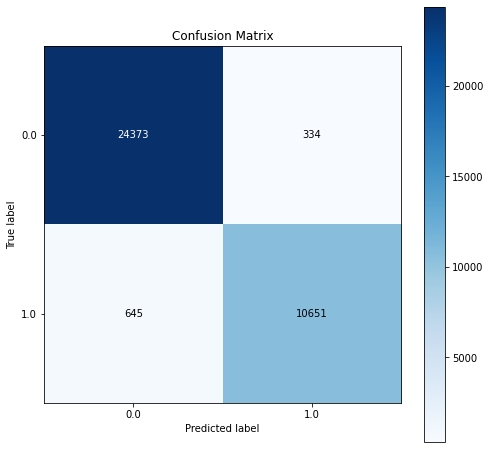

In [31]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_valid, 
    y_valid_preds_dense.round(),
    figsize=(8,8))

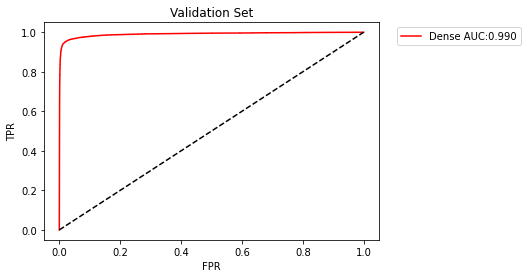

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix




fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)
plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)


plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()




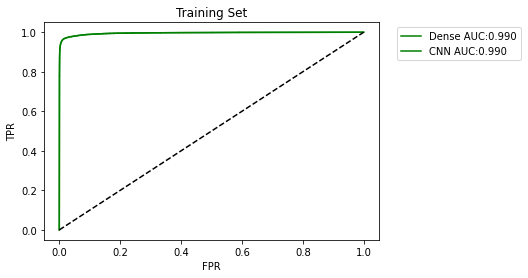

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix

fpr_valid, tpr_valid, t_valid = roc_curve(y_train,y_train_preds_dense)
auc_valid = roc_auc_score(y_valid, y_valid_preds_dense)
plt.plot(fpr_valid, tpr_valid, 'g-', label = 'Dense AUC:%.3f'%auc_valid_dense)

plt.plot(fpr_valid, tpr_valid, 'g-', label = 'CNN AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Training Set')
plt.show()


# **so, DNN(Deep Neural Network) algorithmn have 96% accuracy, 99% AUC(Area Under Curve) and 94% Precision**